GitHub link: https://github.com/cridaflo/Fourier-Transform-workshop
<div>
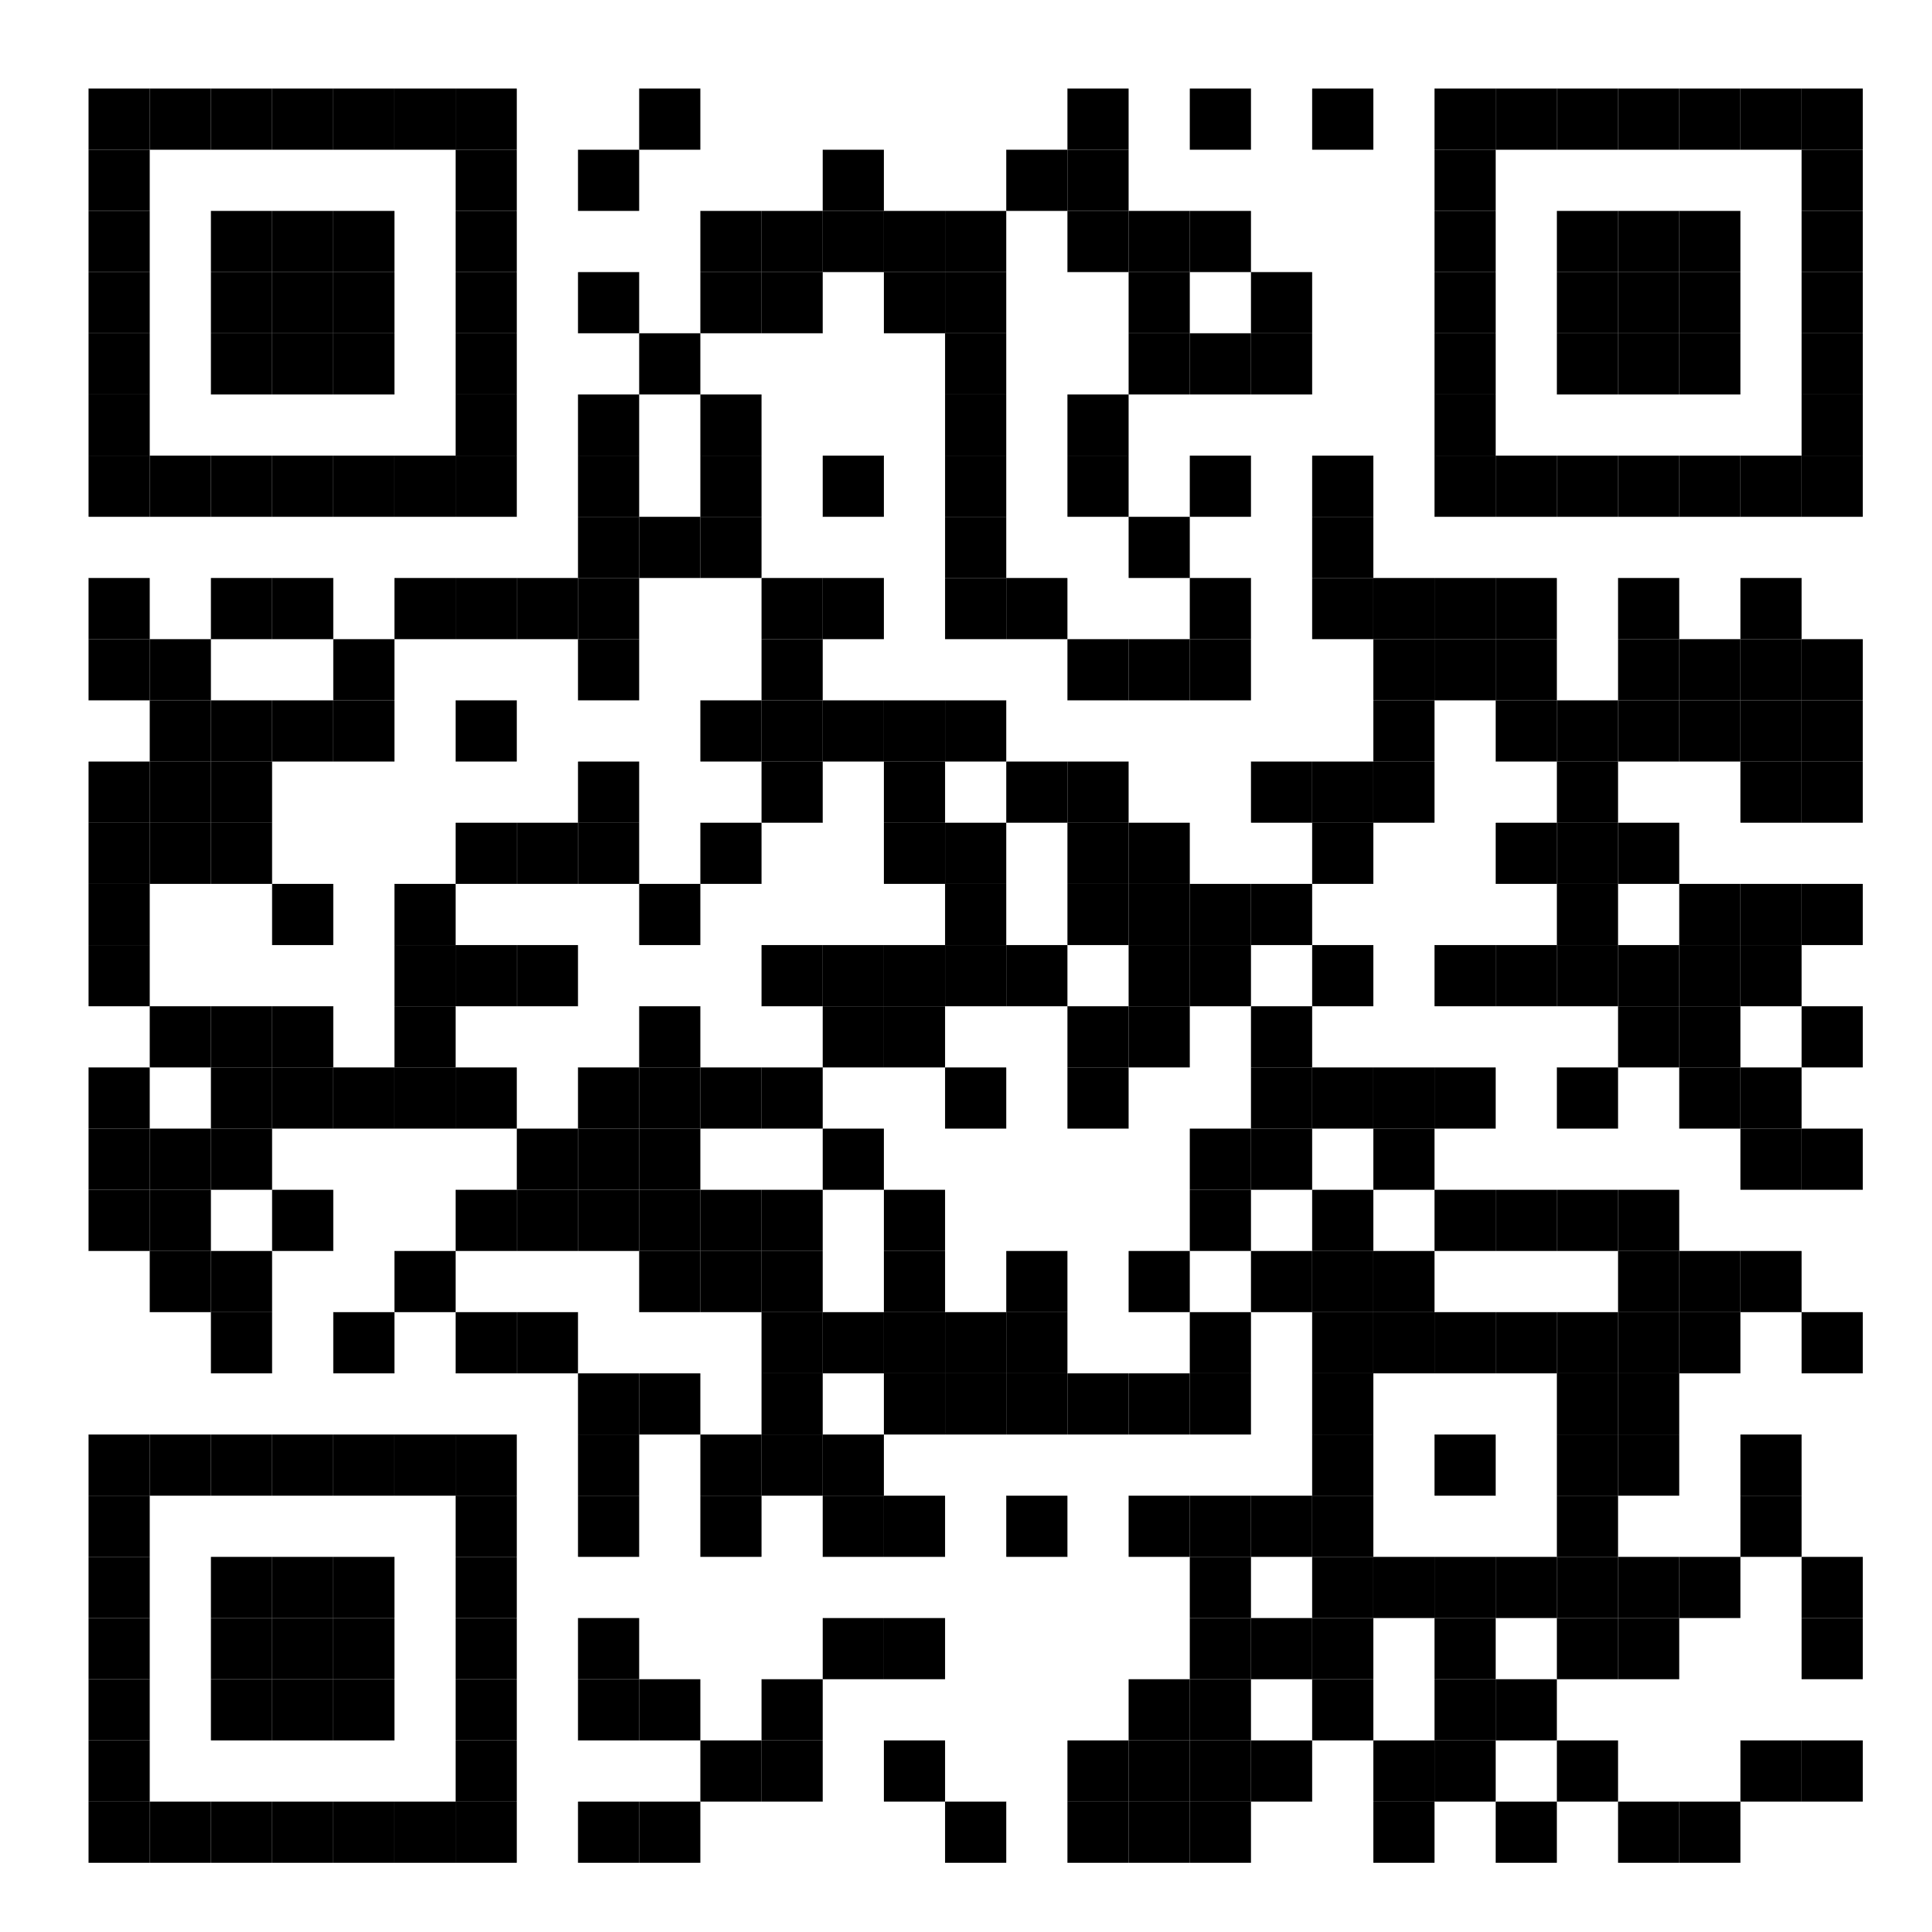
</div>


In [4]:
import numpy as np
from scipy.io import wavfile
import scipy.io
from scipy.fft import fft, fftfreq, ifft
from scipy.io.wavfile import write
from scipy import signal
from pydub import AudioSegment
from pydub.playback import play
from math import pi
from matplotlib import pyplot as plt
from IPython.display import Audio, display
import soundfile as sf
import cmath
import matplotlib.colors as col
import matplotlib.image as mpimg
from scipy import ndimage

c:\users\crida\appdata\local\programs\python\python39\lib\site-packages\pydub\utils.py:170: RuntimeWarning: Couldn't find ffmpeg or avconv - defaulting to ffmpeg, but may not work
  warn("Couldn't find ffmpeg or avconv - defaulting to ffmpeg, but may not work", RuntimeWarning)


# Fourier series

Periodic functions can be represented as infinite sums of sines and cosines

$$f(x) = A_0 + \sum_{n=1}^{\infty} A_n \sin{\left(\frac{2\pi n x}{T}\right)} +  B_n \cos{\left(\frac{2\pi n x}{T}\right)}$$

Where
$$A_0 = \frac{1}{P}\int_{-T/2}^{T/2}f(x) \, dx$$
$$A_n = \frac{2}{P}\int_{-T/2}^{T/2}f(x) \cos{\left(\frac{2 \pi n x}{T}\right)} \, dx$$
$$B_n = \frac{2}{P}\int_{-T/2}^{T/2}f(x) \sin{\left(\frac{2 \pi n x}{T}\right)} \, dx$$

In [5]:
def fourier_sum(A0, As, Bs, T):
    x = np.linspace(0, 10, 1000)
    y = np.zeros(1000)
    for i in range(len(y)):
        y[i] = A0
        for n, a in enumerate(As):
            y[i] = y[i] + a*np.sin(2*pi*(n+1)*x[i]/T)
        for n, b in enumerate(Bs):
            y[i] = y[i] + b*np.cos(2*pi*(n+1)*x[i]/T)
    plt.plot(x, y)
    plt.show()


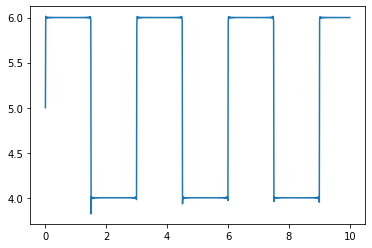

In [10]:
def get_square_coefficients(n):
    ans = []
    for i in range(1, n+1):
        if i % 2 == 0:
            ans.append(0)
        else:
            val = 4/(pi * i)
            ans.append(val)
    return ans, [0]*n

n = 1000
As, Bs = get_square_coefficients(n)
fourier_sum(5,As, Bs, 3)

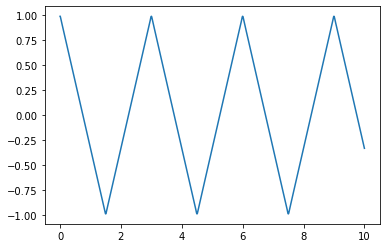

In [12]:
def get_triangle_coeficients(n):
    ans = []
    for i in range(1, n+1):
        if i%2 == 0:
            ans.append(0)
        else:
            val = 8/(pi*pi*i*i)
            ans.append(val)
    return [0]*n, ans

n = 50
As, Bs = get_triangle_coeficients(n)
fourier_sum(0,As, Bs, 3)

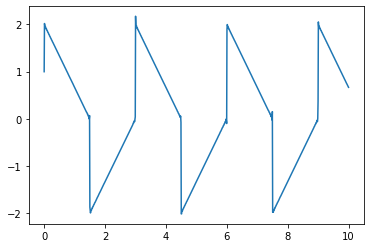

In [14]:
n = 500
As, _ = get_square_coefficients(n)
_ , Bs = get_triangle_coeficients(n)
fourier_sum(0,As, Bs, 3)

## Exponential form

Expressing function in terms of sines and cosines is not very practical


We can leverage the following equations:
$$ e^{ix} = \cos{(x)} + i\sin{(x)}$$



And get
$$f(x) =\sum_{n=-\infty}^{\infty} c_n \cdot e^{\frac{2\pi i n x}{T}}$$
Where 
$$ c_n = \frac{1}{T} \int_{-T/2}^{T/2} f(x) e^{\frac{2\pi i n x}{T}} \, dx$$
    

In [15]:
i = complex(0, 1)

def generate_complex_coefficients(A0, As, Bs, maxi):
    cs = np.zeros(2*maxi+1, dtype=complex)
    cs[0] = A0
    for n in range(maxi):
        cs[n+1] = complex(Bs[n]/2, -As[n]/2)
        cs[-n-1] = complex(Bs[n]/2, As[n]/2)
    return cs

def complex_fourier_sum(cs, T, maxi):
    x = np.linspace(0, 10, 1000)
    y = np.zeros(1000, dtype=complex)
    for pos in range(len(x)):
        for n in range(-maxi, maxi+1):
            y[pos] = y[pos] + cs[n]*cmath.exp(2*pi*i*n*x[pos]/T)
    plt.plot(x, y)
    plt.show()

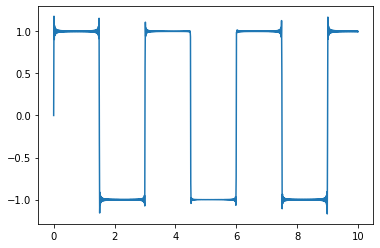

In [17]:
n = 150
As, Bs = get_square_coefficients(n)
cs = generate_complex_coefficients(0, As, Bs, n)
complex_fourier_sum(cs, 3, n)

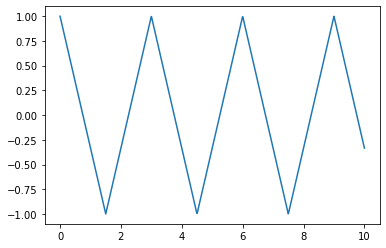

In [20]:
n = 500
As, Bs = get_triangle_coeficients(n)
cs = generate_complex_coefficients(0, As, Bs, n)
complex_fourier_sum(cs, 3, n)

# Fourier Transform

What if the function is not periodic?

In this case we have a continuum of frequencies

$$\mathscr{F}\{f\} = \hat{f}(\xi) =  \int_{-\infty}^{\infty} f(x) e^{-2\pi i\xi x} \, dx$$

Function $\hat{f}$ is said to be in the frequency domain.

The transformation is invertible. Thus, the original function can be recovered from it by the following relation:
$$\mathscr{F}^{-1}\{\hat{f}\} = f(x) =  \int_{-\infty}^{\infty} \hat{f}(x) e^{2\pi i\xi x} \, d\xi$$

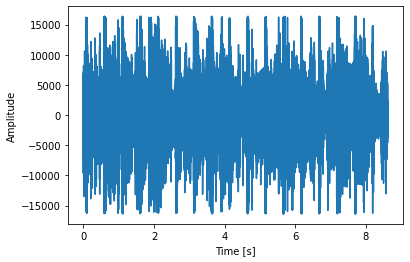

In [21]:
wav_fname = 'example_1.wav'
samplerate, data = wavfile.read(wav_fname)
length = data.shape[0] / samplerate
time = np.linspace(0., length, data.shape[0])
plt.plot(time, data)
plt.xlabel("Time [s]")
plt.ylabel("Amplitude")
plt.show()

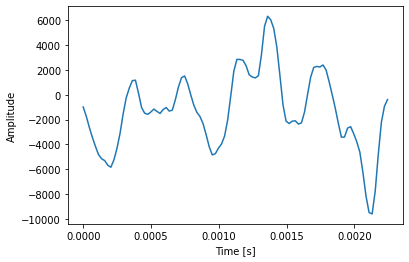

In [22]:
plt.plot(time[:100], data[:100])
plt.xlabel("Time [s]")
plt.ylabel("Amplitude")
plt.show()

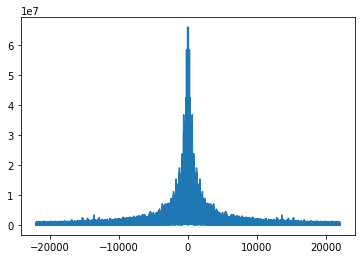

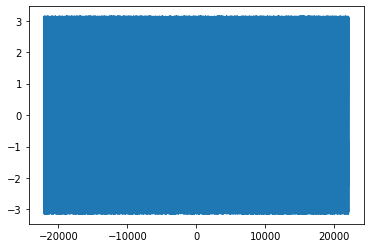

In [24]:
yf = fft(data)
xf = fftfreq(data.shape[0], 1 / samplerate)
plt.plot(xf, np.abs(yf))
plt.show()

plt.plot(xf, np.angle(yf))
plt.show()

In [25]:
audio = AudioSegment.from_wav("example_1.wav")
play(audio)

# Discrete Fourier Transform

In real life we usually don't deal with analytic functions.

Instead we have finite arrays of sampled values.

We use a related transformation which takes these values and produces a sequence of samples in frequency domain.



Given a list of equally spaced samples ${\{x_n\}}_{n \in N}$ we get a sequence ${\{X_k\}}_{k \in N}$ of equally spaced samples in frequency domain. 

$$X_k = \sum_{n=0}^{N-1} x_n \cdot e^{-\frac{2\pi i kn}{N}}$$


The distance between these samples is the inverse of the sampling frequency of the original sequence.

Once again, this operation is invertible.

We can recover the original sequence by the following operation:

$$x_n = \frac{1}{N}\sum_{k = 0}^{N-1} X_k \cdot e^{\frac{2 \pi i k n}{N}}$$

This is the operation that is actually performed by computers when we speak about Fourier Transform.

The algorithm used to calculate this efficiently is called Fast Fourier Transform (FFT).

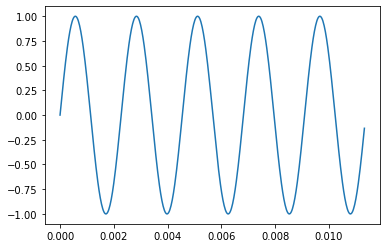

In [26]:
def generate_sine_wave(freq, sample_rate, duration):
    x = np.linspace(0, duration, sample_rate * duration, endpoint=False)
    frequencies = x * freq
    y = np.sin((2 * np.pi) * frequencies)
    return x, y

SAMPLE_RATE = 44100
DURATION = 5
x, y = generate_sine_wave(440, SAMPLE_RATE, DURATION)
plt.plot(x[: 500], y[:500])
plt.show()

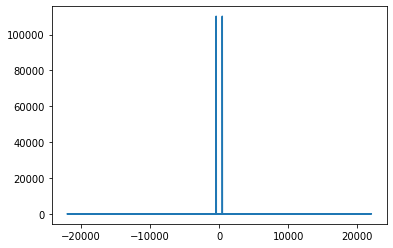

In [27]:
yf = fft(y)
xf = fftfreq(x.shape[0], 1 / SAMPLE_RATE)

plt.plot(xf, np.abs(yf))
plt.show()


In this example, please remember the following equation:
$$ \sin{(x)} = \frac{1}{2i} e^{x i} - \frac{1}{2i} e^{-x i} $$

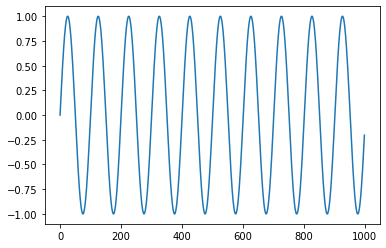

In [28]:
recovered = ifft(yf)
plt.plot(recovered[:1000])
plt.show()

In [29]:
normalized_tone = np.int16((y / y.max()) * 32767)
write("mysinewave.wav", SAMPLE_RATE, normalized_tone)

audio = AudioSegment.from_wav("mysinewave.wav")
play(audio)

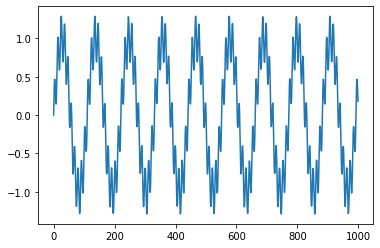

In [30]:
_, nice_tone = generate_sine_wave(400, SAMPLE_RATE, DURATION)
_, noise_tone = generate_sine_wave(4000, SAMPLE_RATE, DURATION)
noise_tone = noise_tone * 0.3
mixed_tone = nice_tone + noise_tone

plt.plot(mixed_tone[:1000])
plt.show()

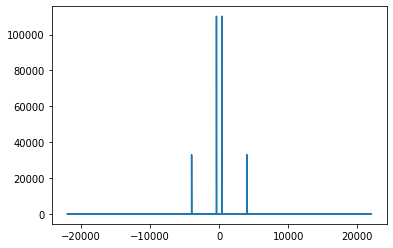

In [31]:
yf = fft(mixed_tone)
xf = fftfreq(mixed_tone.shape[0], 1 / SAMPLE_RATE)

plt.plot(xf, np.abs(yf))
plt.show()

Let’s work with a more realistic example

In [34]:
audio = AudioSegment.from_wav("piano_1.wav")
play(audio)

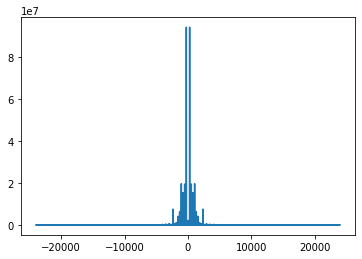

In [33]:
samplerate1, data1 = wavfile.read('piano_1.wav')

yf1 = fft(data1)
xf1 = fftfreq(data1.shape[0], 1 / samplerate1)

plt.plot(xf1, np.abs(yf1))
plt.show()

In [35]:
audio = AudioSegment.from_wav("piano_3.wav")
play(audio)

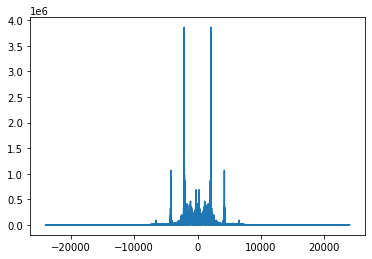

In [36]:
samplerate3, data3 = wavfile.read('piano_3.wav')

yf3 = fft(data3)
xf3 = fftfreq(data3.shape[0], 1 / samplerate3)

plt.plot(xf3, np.abs(yf3))
plt.show()

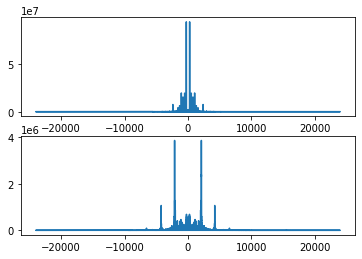

In [37]:
fig, axs = plt.subplots(2)
axs[0].plot(xf1, abs(yf1))
axs[1].plot(xf3, abs(yf3))

Now we can investigate the square function.

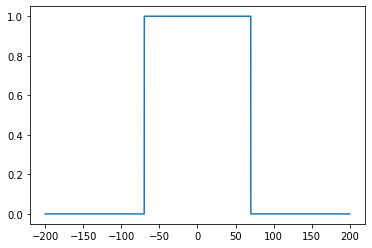

In [38]:
def generate_square_signal(sample_rate, max_freq, cutoff):
    x = np.linspace(-max_freq, max_freq, 2*sample_rate*max_freq, endpoint=False)
    y = [1 if abs(val) <= cutoff else 0 for val in x]
    return x, y

x, y = generate_square_signal(SAMPLE_RATE, 200, 70)
plt.plot(x, y)
plt.show()

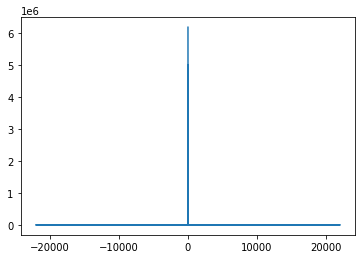

In [41]:
yf = fft(y)
xf = fftfreq(x.shape[0], 1 / SAMPLE_RATE)
plt.plot(xf, np.abs(yf))
plt.show()

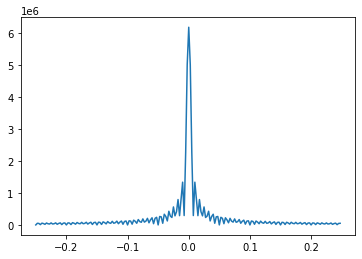

In [42]:
width = 100
xz = np.concatenate((xf[-width:], xf[:width]))
yz = np.concatenate((yf[-width:], yf[:width]))
plt.plot(xz, np.abs(yz))
plt.show()

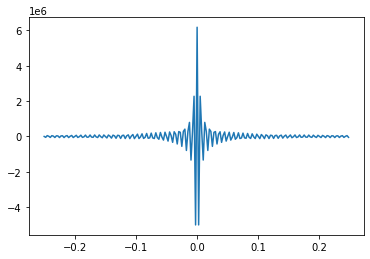

In [43]:
plt.plot(xz, yz)
plt.show()

# Convolution

Given two functions $f$ and $g$ we define the convolution of them as follows:

$$(f*g)(t) = \int_{-\infty}^{\infty}f(\tau)g(t-\tau) \,  d\tau$$

In graphical terms the following process is being a applied to the functions:

- The function $g$ is reflected over the y-axis.
- The function $g$ is translated $t$ to the right. For negative values this ends up in a translation to the left.
- Translated $g$ function is multiplied pointwise with $f$.
- The area under the curve of the resulting function is calculated.
- This is the value of $f*g$ at point $t$.

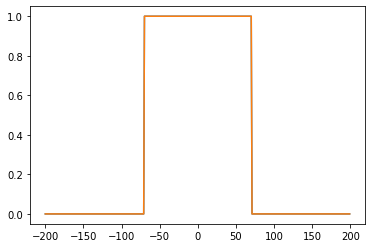

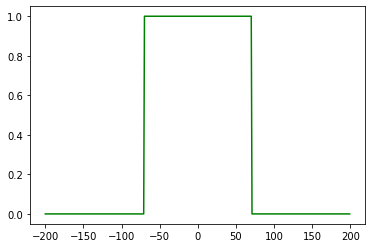

In [50]:
x, square_base = generate_square_signal(1, 200, 70);

def square_function(x):
    if abs(x) >= 200:
        return 0
    return square_base[int(x)+200]

def f(xs):
    return [square_function(x) for x in xs]

def g(xs, t = 0):
    return [square_function(x-t) for x in xs]

def fg(x, t):
    mf = f(x)
    mg = g(x, t)
    return [mf[i]*mg[i] for i in range(len(mf))]

t = 0
plt.plot(x, f(x))
plt.plot(x, g(x, t))
plt.show()
plt.plot(x, fg(x, t), color='green')
plt.show()


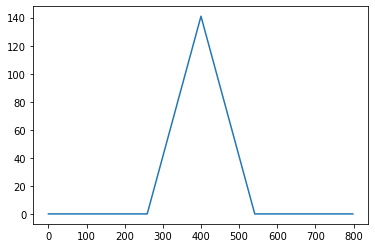

In [49]:
convolved_square = signal.convolve(square_base, square_base)
plt.plot(convolved_square)
plt.show()

For discrete time it has the same graphical interpretation. In this case the operation is formulated in terms of sums:

$$(f*g)[n] = \sum_{k = -\infty}^{\infty} f[k]g[n-k]$$

When the arrays are finite, they are padded with zeros to make the calculations.

The resulting vector is larger than the original one, with length equal to the sum of the base length minus one.

In this case the convolution corresponds to polynomial multiplication.

Let $p_1 = 1+x+x^2$ and $p2 = 1+2x^2$ then:
$$p_1 \cdot p_2 = (1+x+x^2) + (2x^2 + 2x^3 + 2x^4) = 1+x + 3x^2 + 2x^3 + 2x^4$$ 

Now, encode the polynomials as vectors $p_1 \rightarrow [1,1,1]$ and $ p_2 \rightarrow [1, 0, 2]$.

And now, let's calculate the convolution of them:

$$[0, 0, 1, 1, 1, 0, 0]$$

$$[2, 0, 1, 0, 0, 0, 0]$$
$$-----------$$
$$[0, 0, 1, 0, 0, 0, 0]$$

So $(p_1*p_2 )[0] = 1$

$$[0, 0, 1, 1, 1, 0, 0]$$

$$[0, 2, 0, 1, 0, 0, 0]$$
$$-----------$$
$$[0, 0, 0, 1, 0, 0, 0]$$

So $(p_1*p_2)[1] = 1$

$$[0, 0, 1, 1, 1, 0, 0]$$

$$[0, 0, 2, 0, 1, 0, 0]$$
$$-----------$$
$$[0, 0, 2, 0, 1, 0, 0]$$

So $(p_1*p_2)[2] = 3$

$$[0, 0, 1, 1, 1, 0, 0]$$

$$[0, 0, 0, 2, 0, 1, 0]$$
$$-----------$$
$$[0, 0, 0, 2, 0, 0, 0]$$

So $(p_1*p_2)[3] = 2$

$$[0, 0, 1, 1, 1, 0, 0]$$

$$[0, 0, 0, 0, 2, 0, 1]$$
$$-----------$$
$$[0, 0, 0, 0, 2, 0, 0]$$

So $(p_1*p_2) [4] = 2$

Thus, $p_1 * p_2 = [1, 1, 3, 2, 2] \rightarrow p_1 \cdot p_2$

Coming back to square signal, convolution with it has some special properties.

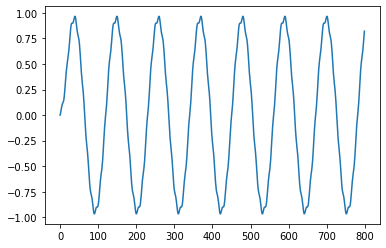

In [51]:
width = 10
_, avf = generate_square_signal(1, 10, width)
avf = [x / (2*width) for x in avf]
convolved = signal.convolve(mixed_tone, avf)
plt.plot(convolved[0: 800])

Noise from signal has been removed!

We can double check looking at frequency domain representation

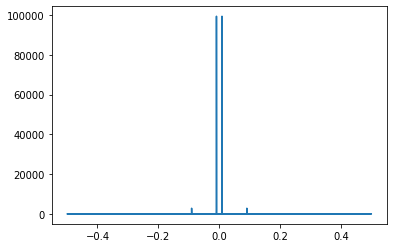

In [52]:
yf = fft(convolved)
xf = fftfreq(yf.shape[0], 1)
plt.plot(xf, np.abs(yf))
plt.show()

This is what is called a moving average filter.
It can be used to remove high frequencies in a signal.

Convolution and Fourier transform are related by the following equation:
$$ f*g = \mathscr{F}^{-1}\{\hat{f} \cdot \hat{g} \}$$

# Filters

A filter is an element that helps to remove frequencies from a signal. There are 4 kinds of filters:
- Low pass filters
- High pass filters
- Band pass filters
- Notch filters

All of them can be obtained from a low pass filter and math operations.
As a consequence, we will focus on low filters in what follows.

## Ideal filters

From definition, a low pass filter is the one that doesn't affect the signal in frequencies below the cutoff one and removes all that are above it.

In fact, this corresponds to multiply a signal in the frequency domain by a square signal.


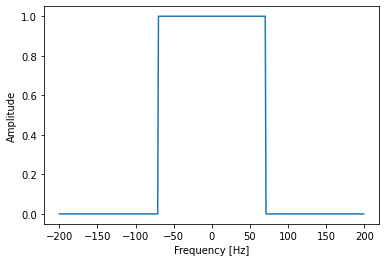

In [53]:
x, square_signal = generate_square_signal(1, 200, 70);
plt.plot(x, square_signal)
plt.xlabel("Frequency [Hz]")
plt.ylabel("Amplitude")
plt.show()


We can now filter the noisy sinusoid with this.

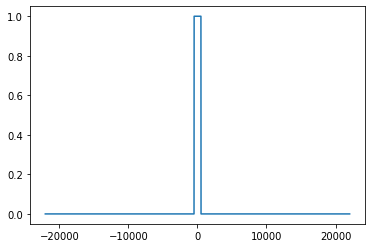

In [54]:
x, my_filter = generate_square_signal(5, 22050, 500)
plt.plot(x, my_filter)
plt.show()

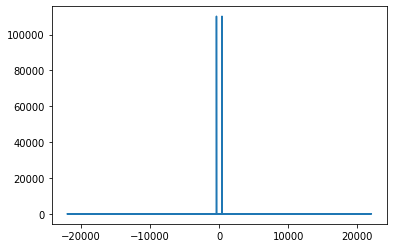

In [55]:
mid = len(x) // 2
my_filter = np.concatenate((np.array(my_filter[-mid:]), np.array(my_filter[:mid])))
yf = fft(mixed_tone)
yf = yf*my_filter
xf = fftfreq(mixed_tone.shape[0], 1 / SAMPLE_RATE)
plt.plot(xf, np.abs(yf))
plt.show()

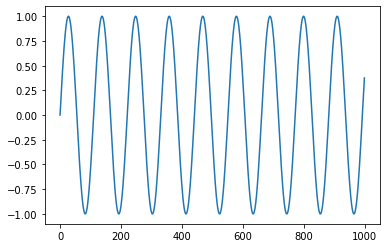

In [56]:
recovered = ifft(yf)
plt.plot(recovered[:1000])
plt.show()


In practice there are problems with ideal low pass filters.
It can be heard in the following example:

In [57]:
# https://freesound.org/s/517633/
audio, fs = sf.read('517633__samuelgremaud__slide-whistle-1.wav')
audio = audio[: , 0]
N = len(audio)
f_cutoff = 500

X = fft(audio)
freqs = fftfreq(N, 1/fs)
X[abs(freqs) >= f_cutoff] = 0

y = ifft(X)

display('Original signal')
display(Audio(data=audio, rate=fs))

display('Ideal LPF, cutoff = 500 Hz')
display(Audio(data=y, rate=fs))
 

'Original signal'

'Ideal LPF, cutoff = 500 Hz'

c:\users\crida\appdata\local\programs\python\python39\lib\site-packages\IPython\lib\display.py:159: ComplexWarning: Casting complex values to real discards the imaginary part
  data = np.array(data, dtype=float)


It can be noticed that there is an annoying audible noise. This is known as ringing.

We can look at the frequency representation of the original signal vs the filtered one.

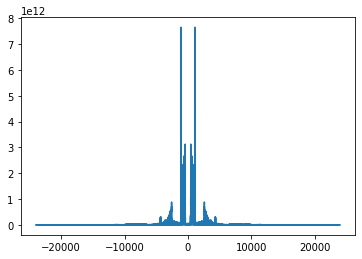

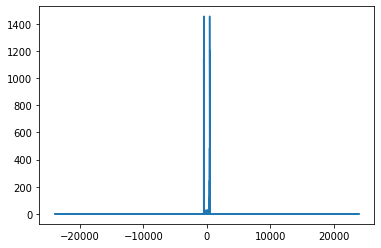

In [58]:
samplerate, audio = wavfile.read('517633__samuelgremaud__slide-whistle-1.wav')
yf_o = fft(audio[:, 0])
xf_o = fftfreq(audio.shape[0], 1 / samplerate)
plt.plot(xf_o, np.abs(yf_o))
plt.show()

yf_i = fft(y)
xf_i = fftfreq(y.shape[0], 1 / fs)
plt.plot(xf_i, np.abs(yf_i))
plt.show()



## Window method

One way to overcome this issue is the window method. This can be thought in the following way:

We start with the ideal low pass filter in the frequency domain:

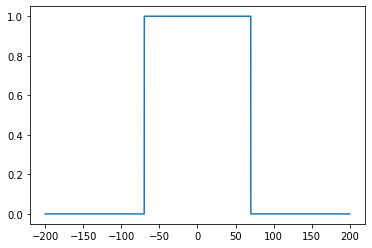

In [59]:
x, y = generate_square_signal(SAMPLE_RATE, 200, 70)
plt.plot(x, y)
plt.show()

We convert it to the time domain.

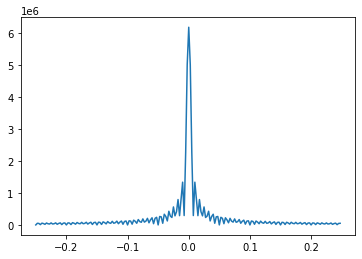

In [60]:
yf = fft(y)
xf = fftfreq(x.shape[0], 1 / SAMPLE_RATE)
width = 100
xz = np.concatenate((xf[-width:], xf[:width]))
yz = np.concatenate((yf[-width:], yf[:width]))
plt.plot(xz, np.abs(yz))
plt.show()


Now, we define a window function and apply it to the filter in the time domain. In this case we will use a Hann window.

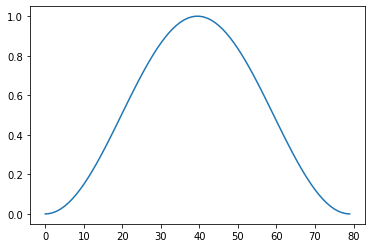

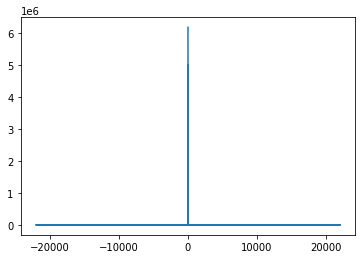

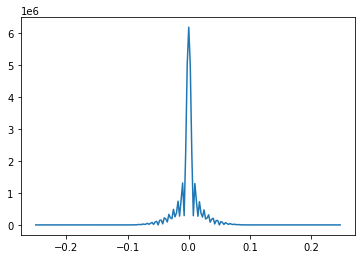

In [61]:
window_len = 80
xf_len = xf.shape[0]
window = signal.windows.hann(window_len)
plt.plot(window)
plt.show()

# Adjust the window to be easily operated
pad_size = (xf_len - window_len) // 2
long_window = np.array(np.pad(window, (pad_size, xf_len - pad_size-window_len), 'constant'))
arranged_window = np.concatenate((long_window[-xf_len//2:], long_window[:xf_len//2]))

windowed = yf*arranged_window
plt.plot(xf, np.abs(windowed))
plt.show()

yw = np.concatenate((windowed[-width:], windowed[:width]))
plt.plot(xz, np.abs(yw))
plt.show()


Finally, we can take the function back to the frequency domain to see what was the impact there.

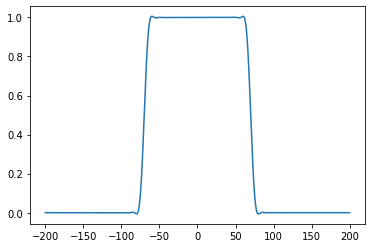

In [62]:
new_sig = ifft(windowed)
plt.plot(x, new_sig)
plt.show()

NOTE: we calculated the filter here step by step for illustrative purposes. Library has implementation to directly generate these types of filters.

Using a pair of these filters, the whistle example sounds as follows:

In [63]:
x, fs = sf.read('517633__samuelgremaud__slide-whistle-1.wav')
x = x[: , 0]

order1 = 2 * fs // f_cutoff
hw1 = signal.firwin(order1, f_cutoff, window='hann', fs=fs)
y_hw1 = signal.convolve(x, hw1, mode='same')

order4 = 16 * fs // f_cutoff
hw4 = signal.firwin(order4, f_cutoff, window='hann', fs=fs)
y_hw4 = signal.convolve(x, hw4, mode='same')

display(f'Hann-windowed low-pass filter, order={order1}')
display(Audio(data=y_hw1, rate=fs))

display(f'Hann-windowed low-pass filter, order={order4}')
display(Audio(data=y_hw4, rate=fs))

'Hann-windowed low-pass filter, order=192'

'Hann-windowed low-pass filter, order=1536'

We can take a look to this filtered signals in the frecuency domain


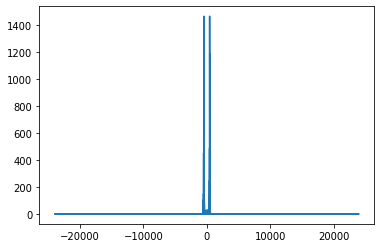

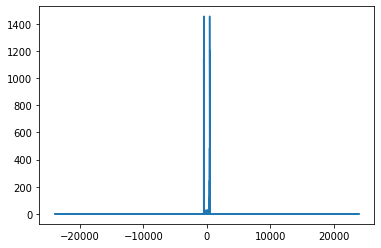

In [64]:
yf_hw4 = fft(y_hw4)
xf_hw4 = fftfreq(y_hw4.shape[0], 1 / fs)

plt.plot(xf_hw4, np.abs(yf_hw4))
plt.show()
plt.plot(xf_i, np.abs(yf_i))
plt.show()

If we zoom in

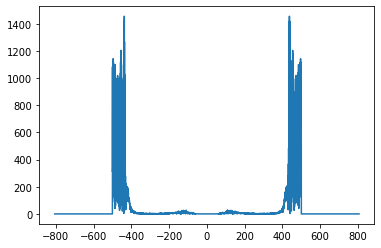

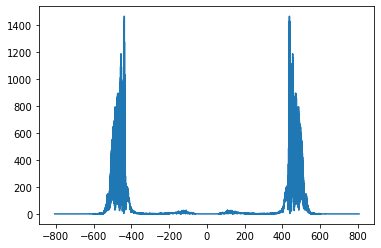

In [65]:
width = 5000

xz = np.concatenate((xf_i[-width:], xf_i[:width]))
yf_iz = np.concatenate((yf_i[-width:], yf_i[:width]))
yf_hw4z = np.concatenate((yf_hw4[-width:], yf_hw4[:width]))
plt.plot(xz, np.abs(yf_iz))
plt.show()

plt.plot(xz, np.abs(yf_hw4z))
plt.show()

## 2D Filters

We can extend the notion of convolution to n-dimensional objects; in particular, to 2D. The illustrative way to calculate this is analogous to what we did with the arrays in one dimensional case.

$$ (f*g)\left[i,j\right]=\sum_{m=-\infty}^\infty\sum_{n=-\infty}^\infty g\left[m,n\right] \cdot h\left[i-m,j-n\right] $$

Let's do an example by hand.

$$
\begin{array}{|c|c|c|c|}
\hline
1 & 1 & 2 & 0\\
\hline
0 & -1 & 0 & 1\\
\hline
1 & 1 & -1 & 1 \\
\hline
0 & -2 & 1 & 1 \\
\hline
\end{array}
*
\begin{array}{|c|c|} 
\hline
2 & -1\\
\hline
0 & 1\\
\hline
\end{array} = 
\begin{array}{|c|c|c|}
\hline
0 & 0 & 5\\
\hline
2 & -3 & 0\\
\hline
-1 & 4 & -2\\
\hline
\end{array}
$$ 

This has many aplications in the field of image processing.
We think the matrix at the left as an image, were each cell corresponds to a pixel and the value on it as the vlaue in grey scale.
Then, we can extrapolate the ideas from one dimensional case to use the right matrix as a filter. In this context such matrix is known as kernel.

One example easy to extrapolate is the moving average filter. In this case we can use a kernel of dimension $n\times n$ where each entry has value $1/n^2$.

<Figure size 432x288 with 0 Axes>

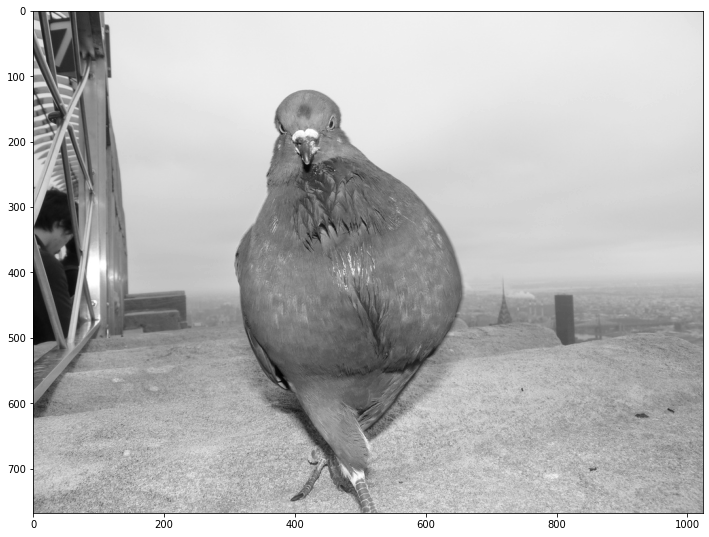

In [66]:
def rgb2gray(rgb_image):
    return np.dot(rgb_image[...,:3], [0.299, 0.587, 0.114])

plt.set_cmap("gray")

figureSize = (12,10)
image = mpimg.imread("pegion.jpg")
image_gr = rgb2gray( image )
plt.figure("Original Image", figsize=figureSize)
plt.imshow(image_gr)

Now we introduce some high frequency noise to the image.

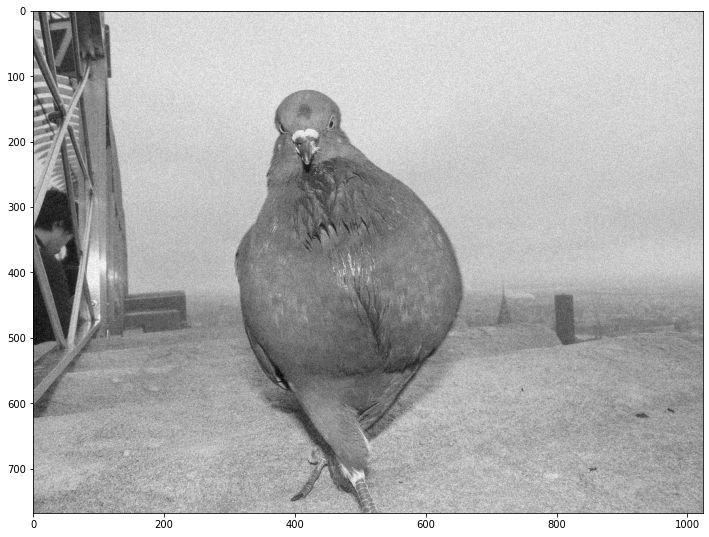

In [67]:
weight = 0.9
noisy = image_gr + weight * image_gr.std() * np.random.random(image_gr.shape)
plt.figure("Noisy Image", figsize=figureSize)
plt.imshow(noisy)

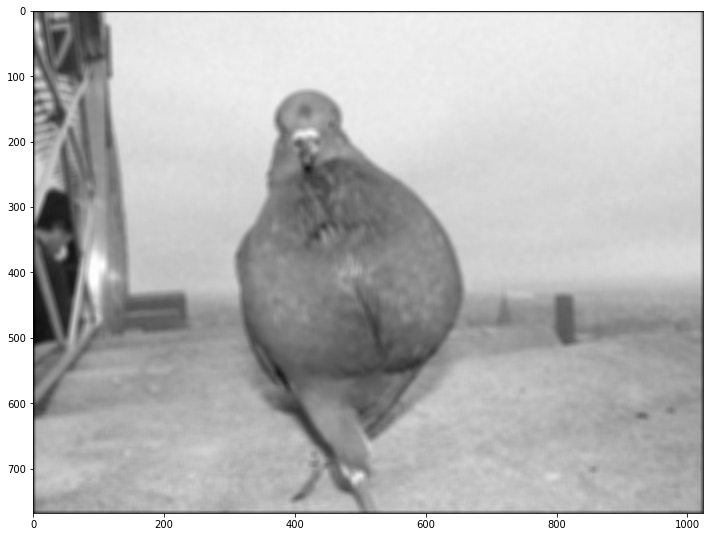

In [70]:
def box_filter( w ):
    return np.ones((w,w)) / (w*w)
    
filtered_img_box5 = signal.convolve2d(noisy, box_filter( 10 ) ,'same')

plt.figure("5",figsize=figureSize)
plt.imshow(filtered_img_box5)


Also, it makes sense to assume that nearer pixels have are more like the central one than those that are further.
Thus, is reasonable to use a gaussian kernel instead.

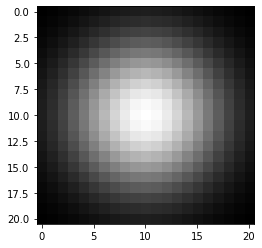

In [72]:
def gaussian_kernel( kernlen , std ):
    gkern1d = signal.gaussian(kernlen, std=std).reshape(kernlen, 1)
    gkern2d = np.outer(gkern1d, gkern1d)
    return gkern2d

plt.imshow(gaussian_kernel(21,5), interpolation='none')

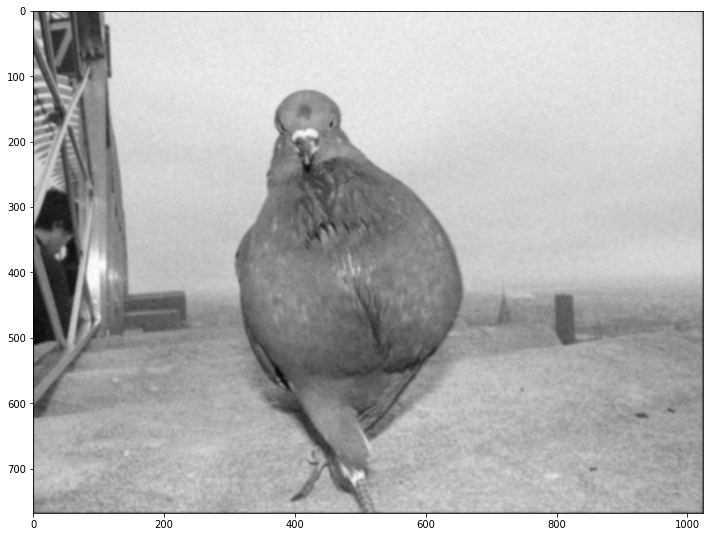

In [73]:
filtered_img_g7_std15 = signal.convolve2d(noisy, gaussian_kernel(7,1.5) ,'same')

plt.figure("5",figsize=figureSize)
plt.imshow(filtered_img_g7_std15)

Other interesting type of filters are the ones to detect edges. The main idea behind the is trying to find places of image that have a high gradient.

## Prewitt operator

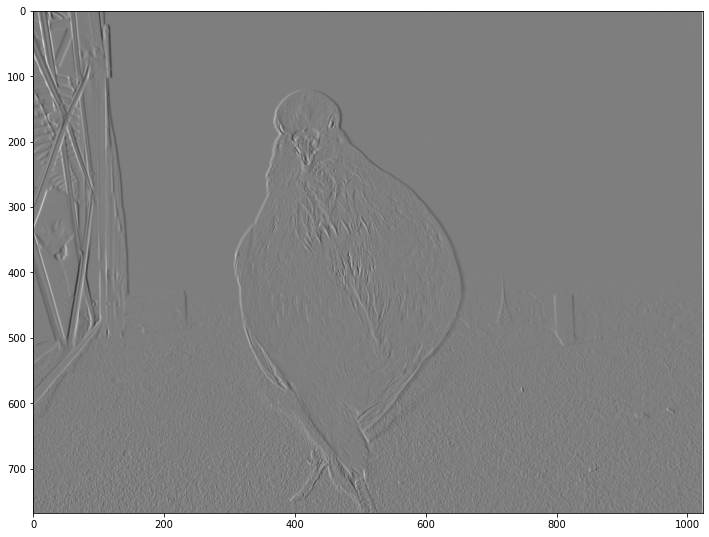

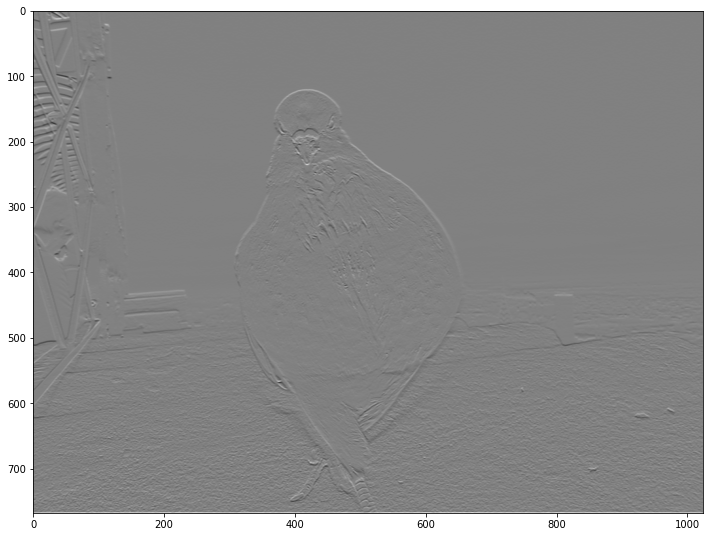

In [74]:
prewitt_h = np.array([[ -1 , 0 , 1 ] ,
                      [ -1 , 0 , 1 ] ,
                      [ -1 , 0 , 1 ] ])
prewitt_v = prewitt_h.transpose()

image_gr_norm = image_gr / 255.
image_prewit_h = signal.convolve2d( image_gr_norm , prewitt_h ,'same')
image_prewit_v = signal.convolve2d( image_gr_norm , prewitt_v ,'same')

plt.figure("Prewit horizontal", figsize=figureSize)
plt.imshow(image_prewit_h)

plt.figure("Prewit vertical", figsize=figureSize)
plt.imshow(image_prewit_v)

## Sobel operator

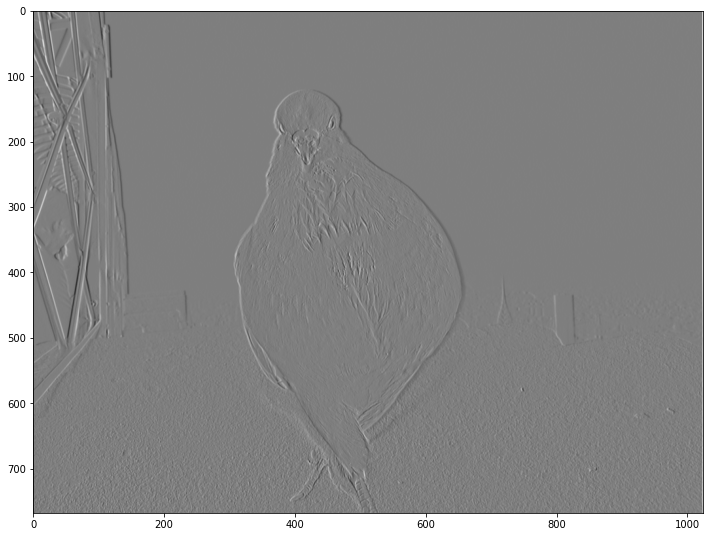

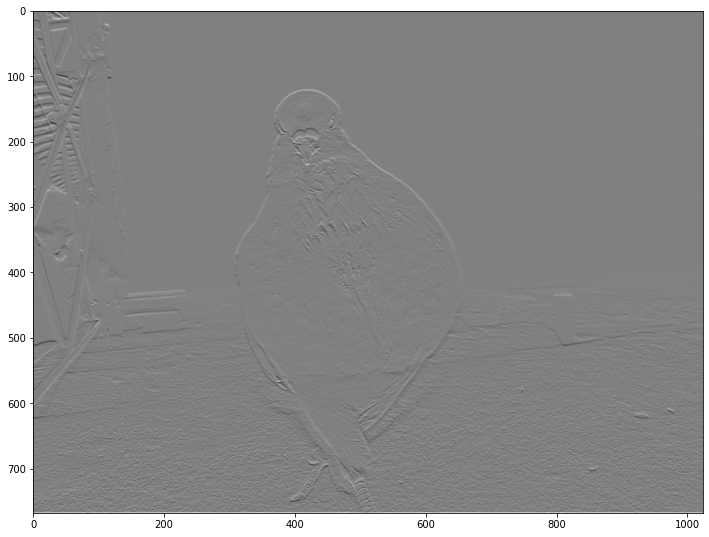

In [75]:
sobel_h = np.array([[ -1 , 0 , 1 ] ,
                    [ -2 , 0 , 2 ] ,
                    [ -1 , 0 , 1 ]])
sobel_v = sobel_h.transpose()

image_sobel_h = signal.convolve2d( image_gr_norm , sobel_h ,'same')
image_sobel_v = signal.convolve2d( image_gr_norm , sobel_v ,'same')

plt.figure("Sobel horizontal", figsize=figureSize)
plt.imshow(image_sobel_h)

plt.figure("Sobel vertical", figsize=figureSize)
plt.imshow(image_sobel_v)

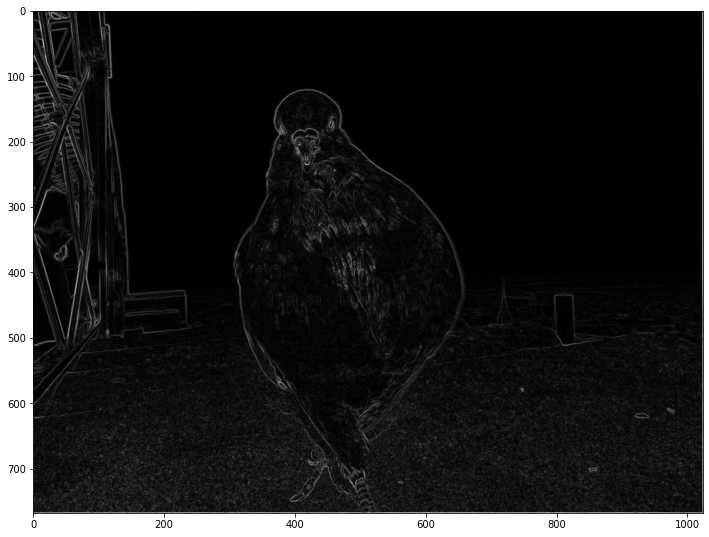

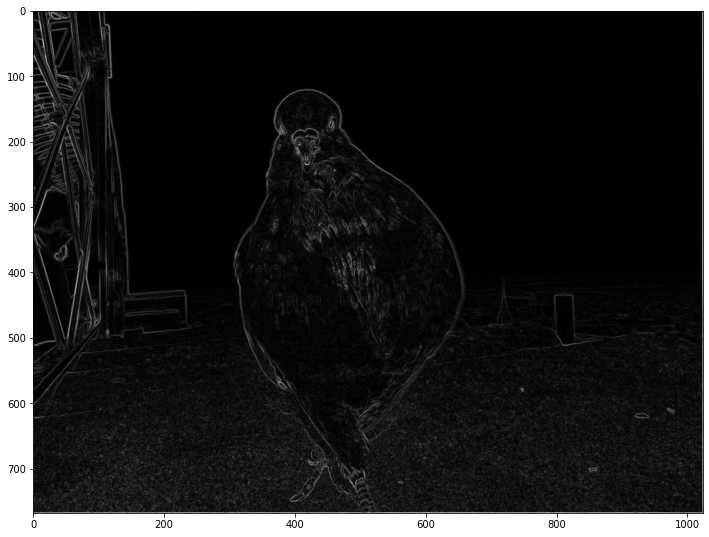

In [76]:
def gradient_sobel( img ):
    image_sobel_h = signal.convolve2d( img , sobel_h ,'same')
    image_sobel_v = signal.convolve2d( img , sobel_v ,'same')
    phase = np.arctan2(image_sobel_h , image_sobel_v) * (180.0 / np.pi)

    # Assign phase values to nearest [ 0 , 45 , 90 ,  135 ]
    phase = ((45 * np.round(phase / 45.0)) + 180) % 180;

    gradient = np.sqrt(image_sobel_h * image_sobel_h + image_sobel_v * image_sobel_v)
    return gradient, phase

image_sobel_gradient, image_sobel_phase = gradient_sobel( image_gr_norm )

plt.figure("Sobel gradient", figsize=figureSize)
plt.imshow(image_sobel_gradient)

plt.figure("Sobel phase", figsize=figureSize)
plt.imshow(image_sobel_gradient)

# References

Alan V. Oppenheim, Alan S. Willsky, and S. Hamid Nawab. 1996. Signals & systems (2nd ed.). Prentice-Hall, Inc., USA.

 Cameron MacLeod. Fourier Transforms With scipy.fft: Python Signal Processing. https://realpython.com/python-scipy-fft/

 Brian McFee. 2020. Digital Signals Theory. https://brianmcfee.net/dstbook-site/content/intro.html

Ahmed M. Badawy. Computer Vision (SBE404B) - Spring. 2019. https://sbme-tutorials.github.io/2021/cv/presentations/3_week3/#2